<a href="https://colab.research.google.com/github/LotanLevy/Crawler/blob/master/pinto_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install tensorflow-gpu==2.3.0

     |████████████████████████████████| 320.4MB 51kB/s 


In [1]:
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

# dataset
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

#Learning data
x_train_s, x_test_s, x_test_b = [], [], []
x_ref, y_ref = [], []

x_train_shape = x_train.shape

for i in range(len(x_train)):
    if y_train[i] == 7: #Sneakers is 7
        temp = x_train[i]
        x_train_s.append(temp.reshape((x_train_shape[1:])))
    else:
        temp = x_train[i]
        x_ref.append(temp.reshape((x_train_shape[1:])))
        y_ref.append(y_train[i])

x_ref = np.array(x_ref)

#6000 randomly extracted from ref data
number = np.random.choice(np.arange(0,x_ref.shape[0]),6000,replace=False)

x, y = [], []

x_ref_shape = x_ref.shape

for i in number:
    temp = x_ref[i]
    x.append(temp.reshape((x_ref_shape[1:])))
    y.append(y_ref[i])

x_train_s = np.array(x_train_s)
x_ref = np.array(x)
y_ref = to_categorical(y)

#test data
for i in range(len(x_test)):
    if y_test[i] == 7: #Sneakers is 7
        temp = x_test[i,:,:,:]
        x_test_s.append(temp.reshape((x_train_shape[1:])))

    if y_test[i] == 9: #Boots is 9
        temp = x_test[i,:,:,:]
        x_test_b.append(temp.reshape((x_train_shape[1:])))

x_test_s = np.array(x_test_s)
x_test_b = np.array(x_test_b)

In [2]:

import cv2
from PIL import Image

def resize(x):
    x_out = []

    for i in range(len(x)):
        img = cv2.cvtColor(x[i], cv2.COLOR_GRAY2RGB)
        img = cv2.resize(img,dsize=(96,96))
        x_out.append(img)

    return np.array(x_out)

X_train_s = resize(x_train_s)
X_ref = resize(x_ref)
X_test_s = resize(x_test_s)
X_test_b = resize(x_test_b)

Model build...
8339456/8331712 [==============================] - 0s 0us/step
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 97, 97, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 16)   432         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 16)   64          Conv1[0][0]                      
_________

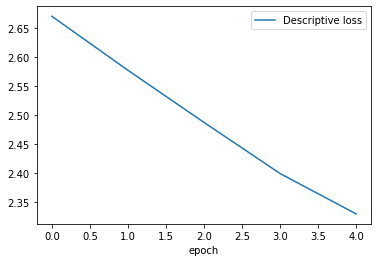

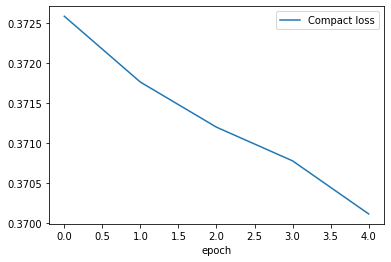

In [4]:
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras import backend as K
#from tensorflow.keras.engine.network import Network

input_shape = (96, 96, 3)
classes = 10
batchsize = 128
#feature_out = 512 #secondary network out for VGG16
feature_out = 1280 #secondary network out for MobileNet
alpha = 0.5 #for MobileNetV2
lambda_ = 0.1 #for compact loss

#Loss function
def original_loss(y_true, y_pred):
    print(y_pred.shape)
    lc = 1/(classes*batchsize)* batchsize**2 * K.sum((y_pred -K.mean(y_pred,axis=0))**2,axis=[1]) / ((batchsize-1)**2)
    return lc

#Learning
def train(x_target, x_ref, y_ref, epoch_num):

    #Read VGG16, S network
    print("Model build...")
    #mobile = VGG16(include_top=False, input_shape=input_shape, weights='imagenet')

    #Read mobile net, S network
    mobile = tf.keras.applications.MobileNetV2(include_top=True, input_shape=input_shape, alpha=alpha, weights='imagenet')

    #Delete last layer
    # mobile.layers.pop()

    #Fixed weight
    for layer in mobile.layers:
        if layer.name == "block_13_expand": # "block5_conv1": for VGG16
            break
        else:
            layer.trainable = False

    model_t = Model(inputs=mobile.input,outputs=mobile.layers[-2].output)

    # #R network　S and Weight sharing
    # model_r = Network(inputs=model_t.input,
    #                   outputs=model_t.output,
    #                   name="shared_layer")

    #Apply a Fully Connected Layer to R
    prediction = Dense(classes, activation='softmax')(model_t.output)
    model_r = Model(inputs=model_t.input,outputs=prediction)

    #Compile
    optimizer = SGD(lr=5e-5, decay=0.00005)
    model_r.compile(optimizer=optimizer, loss="categorical_crossentropy")
    model_t.compile(optimizer=optimizer, loss=original_loss)

    model_t.summary()
    model_r.summary()

    print("x_target is",x_target.shape[0],'samples')
    print("x_ref is",x_ref.shape[0],'samples')

    ref_samples = np.arange(x_ref.shape[0])
    loss, loss_c = [], []

    print("training...")

    #Learning
    for epochnumber in range(epoch_num):
        x_r, y_r, lc, ld = [], [], [], []

        #Shuffle target data
        np.random.shuffle(x_target)

        #Shuffle reference data
        np.random.shuffle(ref_samples)
        for i in range(len(x_target)):
            x_r.append(x_ref[ref_samples[i]])
            y_r.append(y_ref[ref_samples[i]])
        x_r = np.array(x_r)
        y_r = np.array(y_r)

        for i in range(int(len(x_target) / batchsize)):

            #Load data for batch size
            batch_target = x_target[i*batchsize:i*batchsize+batchsize]
            batch_ref = x_r[i*batchsize:i*batchsize+batchsize]
            batch_y = y_r[i*batchsize:i*batchsize+batchsize]

            #target data
            #Get loss while learning
            lc.append(model_t.train_on_batch(batch_target, np.zeros((batchsize, feature_out))))

            #reference data
            #Get loss while learning
            ld.append(model_r.train_on_batch(batch_ref, batch_y))

        loss.append(np.mean(ld))
        loss_c.append(np.mean(lc))

        if (epochnumber+1) % 5 == 0:
            print("epoch:",epochnumber+1)
            print("Descriptive loss:", loss[-1])
            print("Compact loss", loss_c[-1])

    #Result graph
    plt.plot(loss,label="Descriptive loss")
    plt.xlabel("epoch")
    plt.legend()
    plt.show()

    plt.plot(loss_c,label="Compact loss")
    plt.xlabel("epoch")
    plt.legend()
    plt.show()    

    return model_t

model = train(X_train_s, X_ref, y_ref, 5)

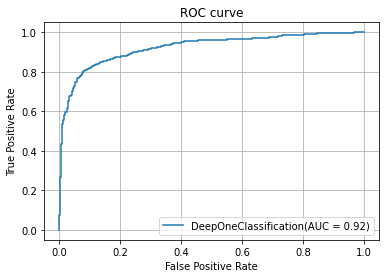

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

train = model.predict(X_train_s)
test_s = model.predict(X_test_s)
test_b = model.predict(X_test_b)

train = train.reshape((len(X_train_s),-1))
test_s = test_s.reshape((len(X_test_s),-1))
test_b = test_b.reshape((len(X_test_b),-1))

#Convert to 0-1
ms = MinMaxScaler()
train = ms.fit_transform(train)
test_s = ms.transform(test_s)
test_b = ms.transform(test_b)

# fit the model
clf = LocalOutlierFactor(n_neighbors=5)
y_pred = clf.fit(train)

#Abnormal score
Z1 = -clf._decision_function(test_s)
Z2 = -clf._decision_function(test_b)

#Drawing of ROC curve
y_true = np.zeros(len(test_s)+len(test_b))
y_true[len(test_s):] = 1 #0:Normal, 1：Abnormal

#Calculate FPR, TPR(, Threshould)
fpr, tpr, _ = metrics.roc_curve(y_true, np.hstack((Z1, Z2)))

#AUC
auc = metrics.auc(fpr, tpr)

#Plot the ROC curve
plt.plot(fpr, tpr, label='DeepOneClassification(AUC = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()